In [4]:
# use anthropic api to generate rationales for dataset
from datasets import load_dataset, Dataset
from anthropic import Anthropic as Anthropic
from dotenv import load_dotenv
from tqdm import tqdm
import pandas as pd
from transformers import AutoTokenizer
from openai import OpenAI
from os import getenv
import json
import matplotlib.pyplot as plt

# Set the maximum column width to display the full content
pd.set_option('display.max_colwidth', None)
tqdm.pandas()
load_dotenv()

c:\Users\jorin\.conda\envs\AGI\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [5]:
# client = Anthropic()

client = OpenAI(
  base_url="https://openrouter.ai/api/v1",
  api_key=getenv("OPENROUTER_API_KEY"),
)

dataset = load_dataset("jeggers/CoT-Collection", split="finetune")
print(dataset)


Generating test_out_dist split: 100%|██████████| 2731/2731 [00:00<00:00, 392376.40 examples/s]

Dataset({
    features: ['final_input', 'final_target', 'question_id', 'Canary String', 'dataset'],
    num_rows: 16000
})


In [6]:
# keep results in a list in case of interruption or failure
results_cache = "rationales.json"

# read cache if exists
try:
    with open(results_cache, "r") as f:
        rationales = json.load(f)
except FileNotFoundError:
    rationales = {}


In [24]:
# generation settings
max_tokens = 250
temperature = 0.0

In [25]:
# anthropic api
def antropic_api_call(prompt, task):
    message = client.messages.create(
        model="claude-3-5-sonnet-20240620",
        max_tokens=max_tokens,
        temperature=temperature,
        system=prompt,
        messages=[
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": task
                    }
                ]
            }
        ]
    )
    return message.content[0].text

In [26]:
# openai api
def openai_api_call(prompt, task):
    completion = client.chat.completions.create(
        model="openai/gpt-4o-mini",
        max_tokens=max_tokens,
        temperature=temperature,
        messages=[
            {
                "role": "system",
                "content": prompt,
            },
            {
                "role": "user",
                "content": task,
            },
        ],
    )
    return completion.choices[0].message.content

In [27]:
anwser_trigger = "ANSWER: "
prompt = f"""Think step-by-step to solve the given task.
Make your rationale as short and concise as possible.
Do not summarize or repeat the task, part of it or your own solution.
Don't use 'Let's approach this problem step by step.' or similar phrases.
At the end, put '{anwser_trigger}' followed by the answer to the task.
Follow the specified format in the task description."""


def generate_rationale(row):
    task, id = row["final_input"], row["question_id"]

    # check if rationale already exists
    if id in rationales:
        return rationales[id]

    res = openai_api_call(prompt, task)
    rationales[id] = res

    # save results to file
    with open(results_cache, "w") as f:
        json.dump(rationales, f)

    return res

In [37]:

# test for 10 samples in the dataset
df = dataset.select(range(0, 5000)).to_pandas()
df['rationale'] = df.progress_apply(generate_rationale, axis=1)

 24%|██▍       | 1206/5000 [07:52<4:38:15,  4.40s/it]

In [29]:
# split generation into rationales and answers
def split_rationale_answer(x):
    if anwser_trigger in x:
        return x.split(anwser_trigger)[0], x.split(anwser_trigger)[1]
    else:
        return x, None
    
df['rationale'], df['answer'] = zip(*df['rationale'].apply(split_rationale_answer))

c:\Users\jorin\.conda\envs\AGI\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Total samples: 1000
Accuracy: 0.482
Average rationale length: 97.008


<Axes: ylabel='Frequency'>

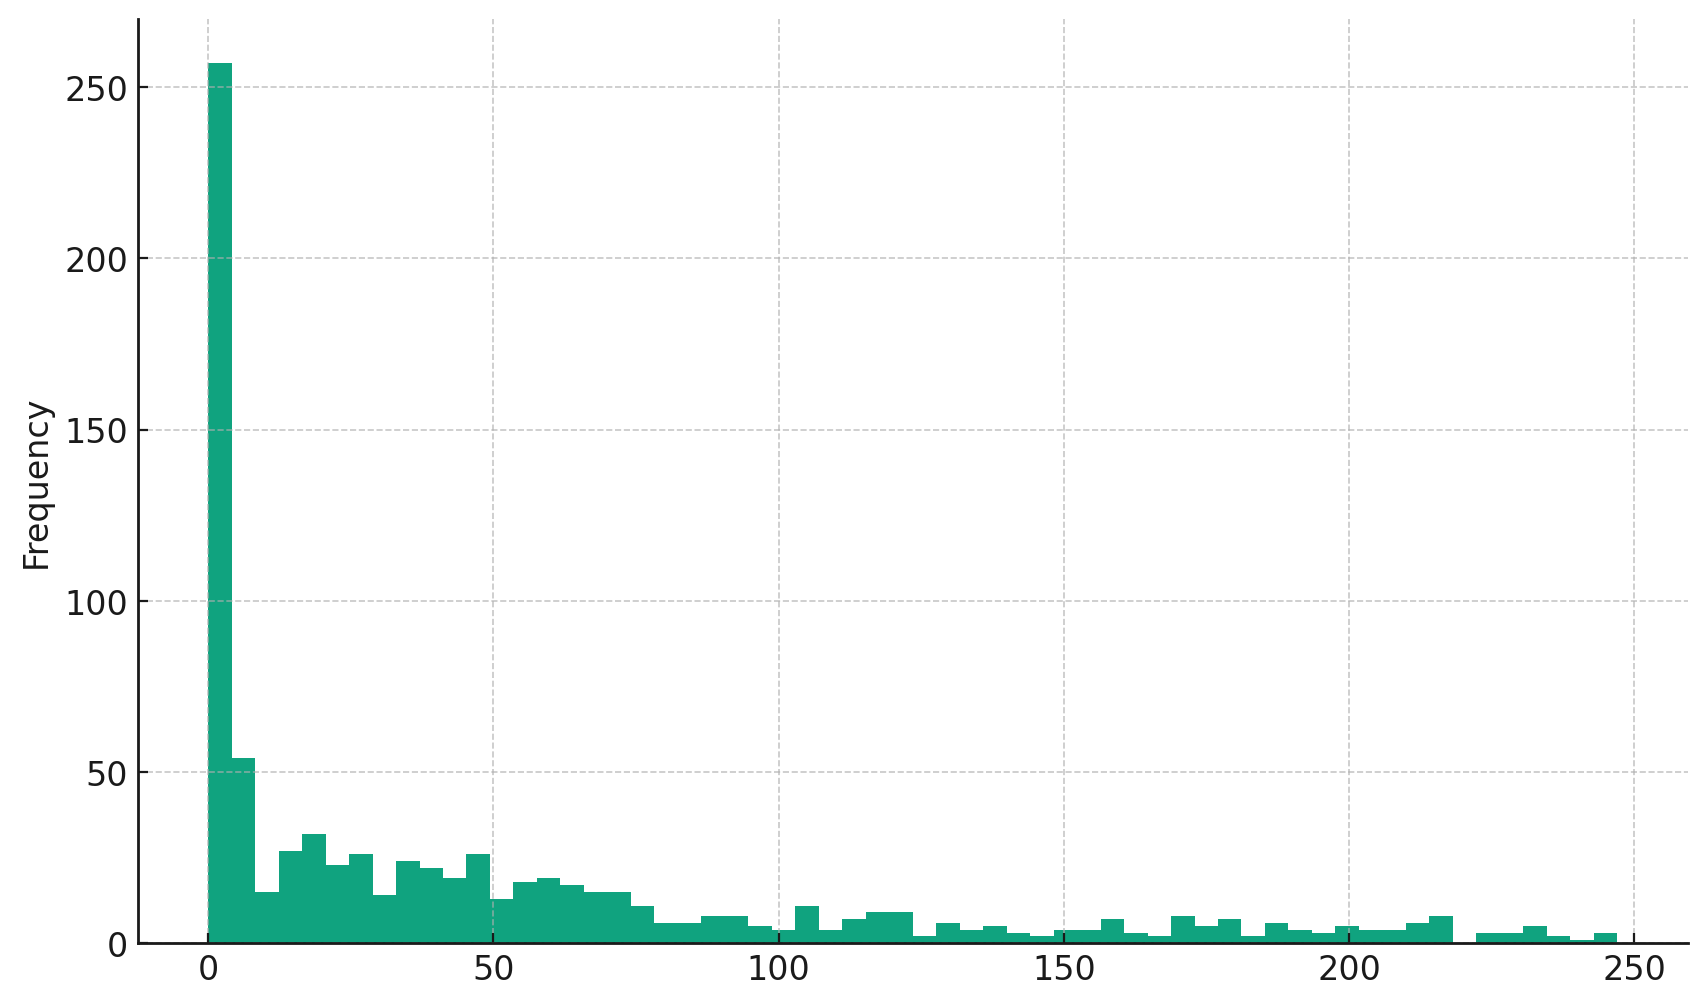

In [34]:
# add rationale length to the dataframe
tokenizer = AutoTokenizer.from_pretrained("facebook/galactica-125M")
df['rationale_length'] = df['rationale'].apply(lambda x: len(tokenizer(x)['input_ids']))

# add column to check if correct
df['correct'] = df['answer'] == df['final_target']

# print accuracy
print(f"Total samples: {len(df)}")
print(f"Accuracy: {df['correct'].mean()}")
print(f"Average rationale length: {df['rationale_length'].mean()}")

# create histogram of rationale lengths
df['rationale_length'][df["rationale_length"]<=max_tokens].plot.hist(bins=60)

In [35]:
# print 10 samples with quetion_id, final_input, rationale, answer, final_target and correct
head = df.head(10)
head[["question_id", "final_input", "rationale", "answer", "final_target", "correct"]]

,question_id,final_input,rationale,answer,final_target,correct
0,SuperGLUE rte: train#2067,"Judge whether the hypothesis is a consequence of the premise. Respond 'entailment' or 'not_entailment'.\n\nPremise:\nThe poll also showed that a higher percentage of Americans (65%) believe that even if the investigation proceedings actually began, Clinton ought not to be removed.\n\nHypothesis:\nAccording to the poll, 65% of Americans believe that Clinton should be removed from office.","The premise states that 65% of Americans believe Clinton ought not to be removed, which directly contradicts the hypothesis that 65% believe he should be removed. \n\n",not_entailment,not_entailment,True
1,ANLI: train#2028,"Consider the premise: Making a pizza<br>Last night I wanted to make a pizza for my friends. I went out that day to buy the dough and cheese. While I was making the pizza I dropped the dough on the ground. All my friends were very sad. We had to eat sandwiches instead.\n\nAnd the hypothesis: a pizza was made by trump\n\nDoes the hypothesis follow from the premise? Answer with 'entailment', 'neutral', or 'contradiction'.","The hypothesis states that a pizza was made by Trump, whereas the premise describes a situation in which the speaker attempted to make a pizza but ended up not being able to because they dropped the dough. Therefore, the hypothesis contradicts the premise.\n\n",contradiction,neutral,False
2,ape210k: train#1916,"The first workshop originally planned to produce 2,736 parts in 48 hours, but actually produced 75 parts per hour, how many more parts per hour than the original plan?\n\nAnswer should be a number, with no commas and rounded to 4 decimal places if applicable.","First, calculate the planned production rate in parts per hour. \n\nOriginal plan for production:\nTotal parts planned = 2736\nTotal hours = 48\n\nPlanned production rate = Total parts / Total hours\nPlanned production rate = 2736 / 48 = 57 parts per hour\n\nNow, determine the actual production rate:\nActual production rate = 75 parts per hour\n\nNext, find the difference between the actual production rate and the planned production rate:\nDifference = Actual production rate - Planned production rate\nDifference = 75 - 57 = 18 parts per hour\n\n",18,18,True
3,ape210k: train#1298,"To build a road with a length of 1,800 meters, the full length (2/15) was repaired in the first week, and the full length (3/20) was repaired in the second week. What fraction of the entire project can be completed?\n\nRespond with a numerical value, rounded to 4 decimals if needed, without a thousands separator.","First, calculate the total fractions repaired in each week.\n\nFor the first week:\n\[\n\frac{2}{15} \text{ of } 1800 = 1800 \times \frac{2}{15} = 240 \text{ meters}\n\]\n\nFor the second week:\n\[\n\frac{3}{20} \text{ of } 1800 = 1800 \times \frac{3}{20} = 270 \text{ meters}\n\]\n\nNow, add the fractions completed in both weeks:\n\[\n\text{Total length repaired} = 240 + 270 = 510 \text{ meters}\n\]\n\nNext, to find the fraction of the entire project completed:\n\[\n\text{Fraction completed} = \frac{510}{1800}\n\]\n\nNow simplify this fraction:\n\[\n\frac{510}{1800} = \frac{51}{180} = \frac{17}{60}\n\]\n\nTo find the numerical value of this fraction:\n\[\n\frac{17}{60} \approx 0.2833\n\]\n\nThus, the fraction of the entire project that can be completed is:\n",0.2833,0.7167,False
4,MathQA: train#2764,"Solve this math problem and pick the correct answer from the given options. Reply with the single letter that matches your choice. Problem: find last digits of ( 1023 ^ 3923 ) + ( 3081 ^ 3921 ) Options: a ) 8 , b ) 9 , c ) 10 , d ) 11 , e ) 12","To find the last digit of \( (1023^{3923}) + (3081^{3921}) \), we first note that we only need to consider the last digits of the bases since the last digit of a number raised to a power depends only on the last digit of the base itself.\n\n1. The last digit of \( 1023 \) is \( 3 \).\n2. The last digit of \( 3081 \) is \( 1 \).\

In [36]:
# filter for olny correct answers
correct = df[df['correct']]

# filter for rationale length > 10 tokens and <= max_tokens
correct = correct[(correct['rationale_length'] > 10) & (correct['rationale_length'] <= max_tokens)]

print(f"#samples: {len(correct)} of {len(df)}")

#samples: 344 of 1000


In [30]:
# to hugggingface dataset
filtered_dataset = Dataset.from_pandas(correct)
filtered_dataset.push_to_hub("jeggers/CoT-Collection-Rationales")

Uploading the dataset shards: 100%|██████████| 1/1 [00:01<00:00,  1.96s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/jeggers/CoT-Collection-Rationales/commit/36f8915bd8199bdb5e2b653b0038812bed966874', commit_message='Upload dataset', commit_description='', oid='36f8915bd8199bdb5e2b653b0038812bed966874', pr_url=None, pr_revision=None, pr_num=None)

# Clear wrong answers from cache

In [ ]:
### CAUTION: DELETE ALL RATIONALES THAT ARE NOT CORRECT ###
### USE ONLY IF YOU ARE SURE ###

# load cache and delete instances where answer is not correct
with open(results_cache, "r") as f:
    rationales = json.load(f)

for id in list(rationales.keys()):
    if id not in correct["question_id"].values:
        del rationales[id]

# save results to file
with open(results_cache, "w") as f:
    json.dump(rationales, f)